# Tutorial: Periodically Driven Materials With Floquet Theory 

In [1]:
using LatticeQM #The Floquet functionality is included in the Floquet module of LatticeQM
using Plots
using Revise

┌ Info: Precompiling LatticeQM [606d2a7e-9b17-11e9-1c5c-455b84f60309]
└ @ Base loading.jl:1273
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273
┌ Warning: Error requiring `HDF5` from `Plots`
│   exception = (LoadError("C:\\Users\\tobyk\\.julia\\packages\\Plots\\uCh2y\\src\\backends\\hdf5.jl", 162, UndefVarError(:HDF5Group)), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00000000668ae2e5, Ptr{Nothing} @0x0000000066884d57, Ptr{Nothing} @0x000000006684e912, Ptr{Nothing} @0x00000000669ea4d0, Ptr{Nothing} @0x00000000669eaafc, Ptr{Nothing} @0x00000000669ea764, Ptr{Nothing} @0x00000000669eb40c, Ptr{Nothing} @0x00000000669eba8e, Base.InterpreterIP(CodeInfo(
    @ C:\Users\tobyk\.julia\packages\Plots\uCh2y\src\backends\hdf5.jl:162 within `top-level scope'
1 ─      $(Expr(:thunk, CodeInfo(
    @ none within `top-level scope'
1 ─     return $(Expr(:method, :_write_datatype_attr))
)))
│        $(Expr(:method, :_write_datatype_attr))
│   %3 = Core

The Floquet module allows for simulating lattices which are externally driven with a periodic potential. This can change things like their band structure and topological phase. We start by opening a gap in graphene by driving it with circularly polarized light as discussed in PHYSICAL REVIEW B 79, 081406(R) (2009).

In order to apply a periodic drive to a static Hamiltonian, we first need to define it using the type `Floquet.periodicDrive` by calling `Floquet.periodicDrive(omega)`, where `omega` is the angular frequency of the drive.

In [2]:
Floquet.periodicDrive(1)

Angular frequency of the periodic drive: 1.0
Non-zero harmonic modes: Integer[]
Fourier components of the driving operator: AbstractArray{T,2} where T[]


As can be seen from the print-out, the `periodicDrive` does not do anything now. To change this, we add the Fourier components of our periodic potential using the `addFreq!` command. These are operators of the same dimension as the static Bloch Hamiltonian which we want to drive. For lattice momenta close to the K-point of graphene we can for example approximate circularly polarized light as the simple potential
\begin{equation}
    V(t) = 
    \begin{pmatrix}
        0 & \tau_z\cdot A \\
        0 & 0
    \end{pmatrix} \exp(-\tau_z \cdot i\omega t) +
    \begin{pmatrix}
        0 & 0 \\
        \tau_z\cdot A & 0
    \end{pmatrix} \exp(\tau_z \cdot i\omega t) \ ,
\end{equation}
where $\tau_z= \pm 1$ labels the chirality (ie K and K' point in graphene), $A$ is the amplitude of the gauge field, and $\omega$ is the frequency of the light. Let us stick to the case $\tau_z=1$. We realize that the non-zero Fourier components are
\begin{equation}
    c_{-1} =
    \begin{pmatrix}
        0 & 0 \\
        A & 0
    \end{pmatrix} \quad \text{and} \quad
    c_{1} =
    \begin{pmatrix}
        0 & A \\
        0 & 0
    \end{pmatrix} \ .
\end{equation}
We therefore add this information to our drive in the following way:

In [3]:
function laserDrive(A::Number, omega::Number)
    d = Floquet.periodicDrive(omega)
    Floquet.addFreq!(d, [0 A; 0 0], 1)
    Floquet.addFreq!(d, [0 0; A 0], -1)
    return d
end

laserDrive (generic function with 1 method)

We already wrapped our drive in a function, such that we can easily vary A and omega later. Alternatively, we could define all this in one go by calling `Floquet.periodicDrive(omega, [[0 0;A 0],[0 A;0 0]], [-1,1])`. This yields the same outcome:

In [4]:
laserDrive(2,50)

Angular frequency of the periodic drive: 50.0
Non-zero harmonic modes: Integer[1, -1]
Fourier components of the driving operator: AbstractArray{T,2} where T[[0 2; 0 0], [0 0; 2 0]]


In [5]:
Floquet.periodicDrive(50, [[0 0;2 0],[0 2;0 0]], [-1,1])

Angular frequency of the periodic drive: 50.0
Non-zero harmonic modes: Integer[-1, 1]
Fourier components of the driving operator: AbstractArray{T,2} where T[[0 0; 2 0], [0 2; 0 0]]


In order to apply this drive to a graphen lattice, we need to define it first, and then simply add the drive as additional argument in the `Spectrum.getbands` function.

In [18]:
#initialize graphene lattice and corresponding path
lat = Geometries2D.honeycomb()
hops = Operators.graphene(lat)
H = Spectrum.getbloch(hops) 
ks = kpath(lat; num_points=300)

Discrete Path: $\Gamma$→$K$→$M$→$K'$→$\Gamma$→$M$  (300 points)


In [19]:
M=50 #cutt-off parameter
bands = Spectrum.getbands(H, ks, laserDrive(2,50), M)

Number of bands:      2
Number of k-points:   300
No observables.
Discrete Path: $\Gamma$→$K$→$M$→$K'$→$\Gamma$→$M$  (300 points)


The additional parameter `M` above decides how much of the Floquet-Hamiltonian is taken into account (see eg [Floquet Engineer's Handbook](https://arxiv.org/abs/2003.08252) on arXive for the details of the procedure). Generally, solving a $d$-dimensional problem with cut-off parameter $M$ requires the diagonalizing of a matrix of dimension $d\cdot(2M+1)$. The accuracy of the method is better for higher frequencies and lower driving amplitudes.

The `BandData` object which is returned is the same as for any time-independent Bloch Hamiltonian. We can for example easily plot it, which reveals the opening of a band gap at the K-point:

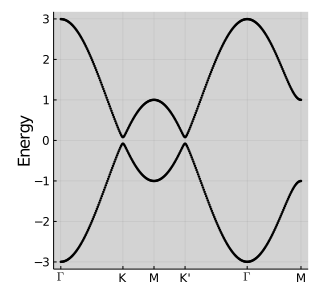

In [20]:
p=plot(bands, dpi=100)
#savefig(p, "graphene_bands.png") #use this to save the Figure

### Topology

We also want to investigate how external driving can change the topology of a system. The above model is not accurate enough for this since the driving potential is a mere approximation, and the obtained result is only valid close to the K-point.

A simple toy-model which can be used to see topological effects is outlined in PHYSICAL REVIEW X 3, 031005 (2013). It consists of a Hamiltonian of the form
\begin{align}
    H_0(\vec{k}) &= \vec{d}(\vec{k})\cdot \vec{\sigma} \ , \\
    \text{with} \quad d_x(\vec{k}) &= a\sin(k_x) \ ,\\
    d_y(\vec{k}) &= a\cos(k_y) \ , \\
    d_z(\vec{k}) &= (\mu-J) -2b(2-\cos(k_x)-\cos(k_y)) + J\cos(k_x)\cos(k_y) \ ,
\end{align}
which is driven by a potential
\begin{equation}
    \Delta(t) = \Delta_0 \cos(\omega t) \sigma_z \ .
\end{equation}

We first implement the time-independent part:

In [21]:
using LinearAlgebra: dot
using LatticeQM.Algebra: σs

In [22]:
#parameters
mu = 1
a = 4
b = 1.5
J = 1.5
#for mu,b,J>0 and mu/b<4 the system is topological (see PHYSICAL REVIEW X 3, 031005 (2013))

#Bloch Hamiltonian
function HB(k, mu, a, b, J)
    d1 = a*sin(k[1])
    d2 = a*sin(k[2])
    d3 = (mu-J) - 2*b*(2 - cos(k[1])- cos(k[2])) + J*cos(k[1])*cos(k[2])
    ds = [d1, d2, d3]
    return sum([ds[i].*σs[i] for i=1:3])
end

HB(k) = HB(k, mu, a, b, J)

HB (generic function with 2 methods)

In [23]:
#Define a path for the model. The one used here is a cut through the BZ in kx direction with ky=0 
using LaTeXStrings
l = 200
pos = collect(LinRange(0, 2*pi, l))
ps = transpose(hcat(collect(LinRange(-pi, pi, l)), zeros(l)))
ts = [0, pi, 2*pi]
tls = [L"-\pi", "0", L"\pi"]
ks2 = Structure.Paths.DiscretePath(ts, tls, pos, ps)

Discrete Path: $-\pi$→$0$→$\pi$  (200 points)


We solve the static Hamiltonian and realize that the band structure is topological by calculating the Chern numbers of the bands. We can do this using the command `Spectrum.getcherns`.

In [24]:
bands2 = Spectrum.getbands(HB, ks2)

Number of bands:      2
Number of k-points:   200
No observables.
Discrete Path: $-\pi$→$0$→$\pi$  (200 points)


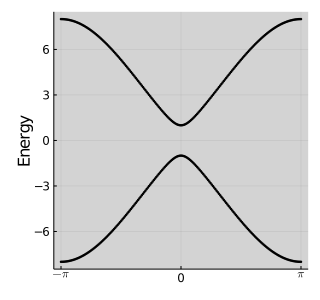

In [25]:
plot(bands2)

In [26]:
#calculate Chern numbers
wf(k) = Spectrum.wavefunctions(HB(2*pi*k.-pi)) #scale the wavefunctions to take arguments from [0,1]
cherns = Spectrum.getcherns(wf, 15, 15) #calculate Chern numbers
println("Chern number of the lower band: "*string(cherns[1]))
println("Chern number of the upper band: "*string(cherns[2]))

Chern number of the lower band: -1.0
Chern number of the upper band: 1.0


Interestingly, we can change these Chern numbers to zero by applying the drive. However, the model is still topologically non-trivial. This is why in the driven case, one should always use the so called _winding number_ (see PHYSICAL REVIEW X 3, 031005 (2013)) to be on the save side. We are demonstrating this here.

First, we define the drive:

In [27]:
#parameters
omega = 100/7.
D = 1
#define drive
drive = Floquet.periodicDrive(omega, [[D 0; 0 -D], [D 0; 0 -D]], [1,-1])

Angular frequency of the periodic drive: 14.285714285714286
Non-zero harmonic modes: Integer[1, -1]
Fourier components of the driving operator: AbstractArray{T,2} where T[[1 0; 0 -1], [1 0; 0 -1]]


Plotting the band structure, we do not see any big change:

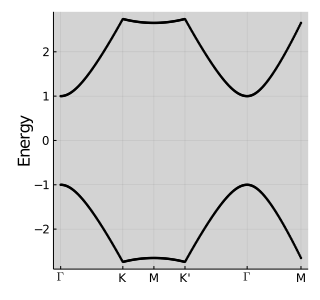

In [28]:
M=2 #truncation parameter
bands3 = getbands(HB, ks, drive, M)
plot(bands3)

To see that the Chern numbers have changed, we can again use the command `Spectrum.getcherns` but with additional arguments for the drive. We can also use the `Spectrum.wavefunction` command to obtain wavefunctions of driven systems.

There is however one key difference here. The wavefunctions which are returned are only eigenfunctions of the Floquet-operator, which governs the time evolution over one full period, and are therefore not identical to the eigenfunctions of the time-evolution operator.

Additionally, the functions are returned in Fourier-space per default. To change this, one could set the `timespace=true`, but this is not necessary here. (Note that the eigenfunctions of the Floquet-operator are time-dependent. `wavefunctions(...;timespace=true)` returns them at time $0$.) Since the wavefunctions are in Fourier space, they also contain the information of all the Floquet bands, also the ones outside the first Floquet Brillouin zone (first FBZ). This means that we have to choose the right bands that correspond to the ones in the plot above (ie the ones in the first FBZ).

The frist FBZ lies in the middle of the spectrum. For a $d$-dimensional Bloch Hamiltonian the relevant bands are the ones with indices $2M+1$ to $2M+d$, where $M$ is the cut-off parameter. So in our case the lower band has index $2M+1$. We can get this Chern number alone using `Spectrum.getcherns(...,[2*M+1])`.

The calculations below show clearly that the drive has changed the Chern numbers of the bands to zero. However, they are still topologically non-trivial, as can be seen in the non-zero winding number.

In [29]:
wf(k) = Spectrum.wavefunctions(HB(2*pi*k.-pi), drive, M) #scale the wavefunctions to take arguments from [0,1]
chern = Spectrum.getcherns(wf, 15, 15, [2*M+1]) #calculate "normal" chern number, will be zeros
windnum = Spectrum.getwindnum(wf, 15, 15, 2*M+1) #calculate winding number, will be -1
println("Chern number of the lower band with drive: "*string(chern[1]))
println("Winding Number of the lower band with drive:"*string(windnum))

Chern number of the lower band with drive: 1.1882855810441129e-16
Winding Number of the lower band with drive:-1.0000000000000004
